To test that linear response theory is recovering the true amplification of freshwater fluxes, we need to evaluate the amplification of fluxes from CESM flux fields. Note that as linear response theory is finding the change in freshwater fluxes as a proportion of the FAFMIP perturbation, the truth is not exactly the change in magnitude of freshwater fluxes, but rather the change of the projection of the freshwater fluxes onto the FAFMIP pattern. There are other ways that we have thought of to quantify the true fluxes which are shown in the "true_freshwater_fluxes_options.ipynb" notebook.

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe

In [2]:
#First, load in all the freshwater fluxes. See notebook processing_salt_fluxes.py for how to generate this files that we unpickle here

import pickle
with open("/scratch/abf376/regridded_salt_flux_historical", "rb") as fp:   #Unpickling, replace string with drectory where pickled file lives
    regridded=pickle.load(fp)

with open("/scratch/abf376/regridded_salt_flux_2005on", "rb") as fp:   #Unpickling
    regridded_2005on=pickle.load(fp)

## First we calculate the true fluxes for the ensemble mean

In [3]:
#average over ensemble member
salt_flux_avg_pre2005=sum(regridded)/34
salt_flux_avg_pre2005=salt_flux_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_pre2005=salt_flux_avg_pre2005.assign_coords(latitude=salt_flux_avg_pre2005.lat[:,0],longitude=salt_flux_avg_pre2005.lon[0,:])

salt_flux_avg_2005on=sum(regridded_2005on)/34
salt_flux_avg_2005on=salt_flux_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_2005on=salt_flux_avg_2005on.assign_coords(latitude=salt_flux_avg_2005on.lat[:,0],longitude=salt_flux_avg_2005on.lon[0,:])

In [4]:
salt_avg=xr.concat([salt_flux_avg_pre2005,salt_flux_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
salt_flux_avg_1970to2019=salt_avg[12*50:12*100,:,:] #salt_avg was from 1920 to 2080 so this is from 1970 to 2019
a=np.linspace(1920,2080,161)
#print(a[50:100])

climatological_salt_flux=salt_avg[0:12*55,:,:].mean('time') #this is 1920 to 1975

In [5]:
#create area grid

import sys
sys.path.insert(1, '/scratch/abf376/')
from area_grid import *

area=area_grid(latitudes=np.array(salt_flux_avg_pre2005[0,:,:].latitude),longitudes=salt_flux_avg_pre2005[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_flux_avg_pre2005[0,:,:].latitude,salt_flux_avg_pre2005[0,:,:].longitude])

In [6]:
#water flux from fafmip
f='/scratch/abf376/FAFMIP_wfo_v2.nc' #this is the first 50 years
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
wfo = xr.open_dataset(f)['water_flux_into_sea_water']
wfo=wfo.where(wfo<1E19)


area_wfo=area_grid(latitudes=np.array(wfo.latitude),longitudes=wfo.longitude)
area_wfo=xr.DataArray(area,dims=["latitude","longitude"],coords=[wfo.latitude,wfo.longitude])

In [7]:
#regrid wfo
ds_out = xe.util.grid_global(1, 1)
regridder_wfo= xe.Regridder(wfo, ds_out, "bilinear",periodic=True)
wfo = regridder_wfo(wfo)
wfo=wfo.rename({'y': 'latitude','x': 'longitude'})
wfo=wfo.assign_coords(latitude=wfo.lat[:,0],longitude=wfo.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [8]:
#now we want to compute the projection of cesm fluxes onto the fafmip perturbation field

y=np.reshape(wfo.mean('time')*area.where(area.latitude<65),(1,180*360)) #reshape the perturbation field to be a vector

proj=np.empty(50)
err=np.empty(50)
for i in range(0,50):
    x=np.reshape(salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')*area.where(area.latitude<65),(1,180*360))
    proj[i]=np.nansum(x*y)/(np.nansum(y*y))
    err[i]=(np.nansum(np.abs(proj[i]*y)))/(np.nansum(np.abs(x-proj[i]*y))) #portion of cesm salt flux explained by projection divided by proportion of salt flux explained by rejection. come back to this

Text(0, 0.5, 'Normalized scalar projection, P(t)')

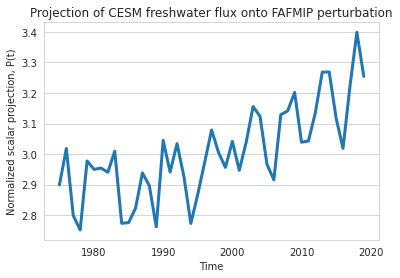

In [9]:
import matplotlib as mpl
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
mpl.rcParams['figure.dpi'] = 100
plt.plot(np.linspace(1975,2019,45),proj[5:50],linewidth=3)
ax.xaxis.grid()
plt.xlabel('Time')
plt.title('Projection of CESM freshwater flux onto FAFMIP perturbation')
plt.ylabel('Normalized scalar projection, P(t)')
#mpl.pyplot.savefig('P(t)_CESM_ensemblemean', dpi=500,bbox_inches='tight')

In [10]:
# do block bootstrapping to deal with effect of natural variability 

np.random.seed(0)

change=np.empty([3000])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=proj[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(proj[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change[i]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())
print(change.mean())
print(change.std())

3.376812828559694e-01
0.07021909954867828


Can instead project the change in the salt fluxes from the beginning of the timeseries. This ultimately is the same thing because $a \cdot (b+c)=a\cdot b + a\cdot c$. Thus, subtracting off the climatological pattern doesn't affect the outcome

In [11]:
#Can compute a slightly different thing which is the projection of the change of the salt flux from the climatological

y=np.array(np.reshape(wfo.mean('time')*area.where(area.latitude<65),(1,180*360))) #reshape the perturbation field to be a vector

proj2=np.empty(50)
s=np.zeros([1,180*360])
for i in range(0,50):
    x=np.array(np.reshape((salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')-salt_flux_avg_1970to2019[0*12:(5)*12,:,:].mean('time'))*area.where(area.latitude<65),(1,180*360)))
    proj2[i]=np.nansum(x*y)/(np.nansum(y*y))
    if i>44:
        s=s+x
s=s/5 #this takes the mean of the last 5 years of x

Text(0, 0.5, 'Normalized scalar projection')

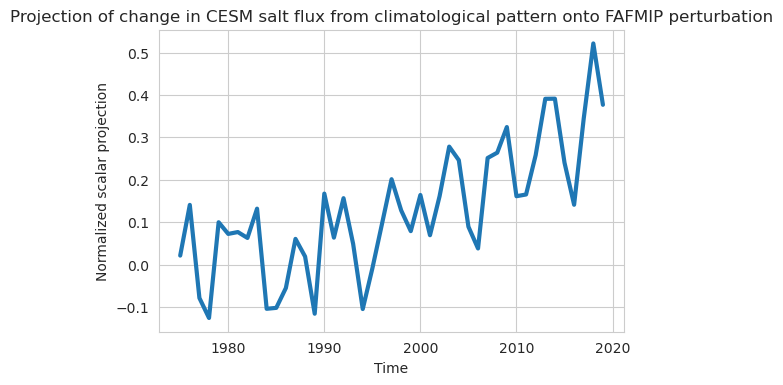

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.plot(np.linspace(1975,2019,45),proj2[5:50],linewidth=3)
plt.xlabel('Time')
plt.title('Projection of change in CESM salt flux from climatological pattern onto FAFMIP perturbation')
plt.ylabel('Normalized scalar projection')

In [15]:
# do block bootstrapping to deal with effect of natural variability 

np.random.seed(0)

change_ensemble=np.empty([3000])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=proj2[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(proj2[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change_ensemble[i]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())
print(change_ensemble.mean())
print(change_ensemble.std())

0.3376812828635823
0.07021909953164686


In [16]:
mask = ~np.isnan(change_ensemble.mean()*y) & ~np.isnan(s)
p=scipy.stats.linregress((change_ensemble.mean()*y)[mask], s[mask], alternative='two-sided')
print(p)

LinregressResult(slope=1.2197751626970665, intercept=-415.24974485674664, rvalue=0.4878334309566982, pvalue=0.0, stderr=0.01170378157672127, intercept_stderr=148.42201807284798)


In [17]:
l=s
l=np.where(y<0,l,np.abs(l))
l=np.where(y>0,l,-np.abs(l))

mask = ~np.isnan(l) & ~np.isnan(s)
p=scipy.stats.linregress(l[mask], s[mask], alternative='two-sided')
print(p)

LinregressResult(slope=0.6589772419128047, intercept=-1595.8733440637561, rvalue=0.6589361835323003, pvalue=0.0, stderr=0.004015362195976948, intercept_stderr=128.76425170382666)


Now we want to quantify the change in the strength of fluxes over time to compare power to

In [18]:
#Find the change in the pattern strength
z1=np.empty(50)
for i in range(0,50):
    z1[i]=np.nansum(np.array(np.reshape((np.abs(salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')-salt_flux_avg_1970to2019[0*12:(5)*12,:,:].mean('time')))*area.where(area.latitude<65),(1,180*360))))

In [19]:
np.random.seed(0)

changez=np.empty([500])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=z1[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(z1[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    changez[i]=(bootstrap[i][42:45].mean()-bootstrap[i][0:3].mean())

print(changez.mean())
print(changez.std())

340018441.7479918
69915636.62975882


In [21]:
#Power of the projection compared to power of the strength of the E-P pattern change (without considering FAFMIP pattern)
np.nansum(np.abs(change_ensemble.mean()*y))/changez.mean()

1.0294024315228003

In [120]:
int_mean=0.38961560370876636 #this is from the true_freshwater_flux_options.ipynb doc
A=((np.abs(wfo.mean('time')))*area.where(area.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded
#For the integration technique let's also check the power of this
(int_mean)*A/changez.mean()

<xarray.DataArray ()>
array(1.14547731)

Let's plot what we're actually looking at here

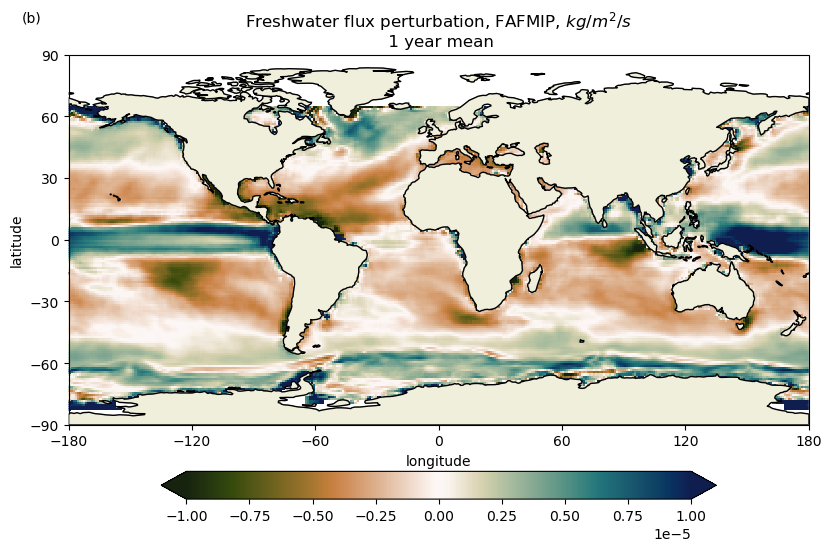

In [32]:
import cmocean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(wfo.mean('time')).where((wfo[0,:,:].latitude<65)).plot(cmap=cmocean.cm.tarn,vmax=1E-5,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Freshwater flux perturbation, FAFMIP, $kg/m^2/s$ \n 1 year mean')
ax.text(-0.05, 1.10, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
fig.tight_layout()
mpl.pyplot.savefig('freshwater_flux_FAFMIP.png', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

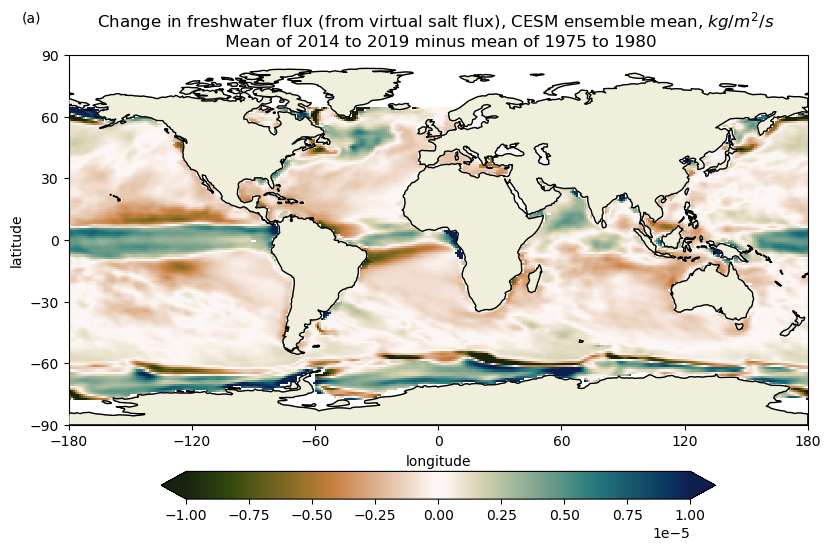

In [33]:

import cmocean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(salt_flux_avg_1970to2019[45*12:50*12,:,:].mean('time')-salt_flux_avg_1970to2019[5*12:10*12,:,:].mean('time')).where(salt_flux_avg_pre2005[0,:,:].latitude<65).plot(cmap=cmocean.cm.tarn,vmax=1E-5,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""},ax=ax,alpha=1) #you have to set a colormap here because plotting xarray infers from the 
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.text(-0.05, 1.10, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.title('Change in freshwater flux (from virtual salt flux), CESM ensemble mean, $kg/m^2/s$  \n Mean of 2014 to 2019 minus mean of 1975 to 1980')
fig.tight_layout()
mpl.pyplot.savefig('freshwater_flux_CESM.png', dpi=500,bbox_inches='tight',facecolor='white',transparent=False)

In [20]:
cs=np.array(np.reshape(salt_flux_avg_1970to2019[47*12:50*12,:,:].mean('time')-salt_flux_avg_1970to2019[5*12:8*12,:,:].mean('time'),(1,180*360)))
fs=np.array(np.reshape(wfo.mean('time').where(wfo[0,:,:].latitude<65),(1,180*360)))

mask = ~np.isnan(fs) & ~np.isnan(cs)
p=scipy.stats.linregress(cs[mask], fs[mask], alternative='two-sided')
print(p)

LinregressResult(slope=0.48535609373146826, intercept=1.4180440490736917e-07, rvalue=0.5251011305001088, pvalue=0.0, stderr=0.004217961718979939, intercept_stderr=1.698308327684326e-08)


## Now, we need to do the same for each individual member

In [18]:
# a list of all ensemble members
for i in range(0,34):
    regridded[i]=regridded[i].rename({'y': 'latitude','x': 'longitude'})
    regridded[i]=regridded[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
    regridded_2005on[i]=regridded_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    regridded_2005on[i]=regridded_2005on[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
salt_avg_list=[]
for i in range(0,34):
    salt_avg_list.append(xr.concat([regridded[i],regridded_2005on[i]],dim="time"))
    
climatological_salt_flux_list=[]
for i in range(0,34):
    climatological_salt_flux_list.append(salt_avg_list[i][0:12*55,:,:].mean('time')) #this is 1920 to 1975
    salt_avg_list[i]=salt_avg_list[i][12*50:12*100,:,:]

In [19]:
proj_list=np.empty([34,50])
for j in range(0,34):
    for i in range(0,50):
        x=np.reshape(salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')*area.where(area.latitude<65),(1,180*360))
        proj_list[j,i]=np.nansum(x*y)/(np.nansum(y*y))

In [21]:
pval_store=np.empty(34)
np.random.seed(0)
change=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=proj_list[j,5:50], alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)
    pval_store[j]=p.pvalue

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(proj_list[j,5:50]-trend, 
                                   block_length=2, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        change[i,j]=(bootstrap[i][40:45].mean()-bootstrap[i][0:5].mean())

mean_boot=np.empty([34])
std_boot=np.empty([34])
for j in range(0,34):
    mean_boot[j]=change[:,j].mean()
    std_boot[j]=change[:,j].std()

As above, we can instead project the change in the salt flux pattern. Ultimately, though, this gives the same value as noted above

In [246]:
proj2_list=np.empty([34,50])
for j in range(0,34):
    for i in range(0,50):
        x=np.reshape((salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')-salt_avg_list[j][0*12:(5)*12,:,:].mean('time'))*area.where(area.latitude<65),(1,180*360))
        proj2_list[j,i]=np.nansum(x*y)/(np.nansum(y*y))

In [247]:
pval_store=np.empty(34)
np.random.seed(0)
change=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=proj2_list[j,5:50], alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)
    pval_store[j]=p.pvalue

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(proj2_list[j,5:50]-trend, 
                                   block_length=2, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        change[i,j]=(bootstrap[i][40:45].mean())

mean_boot2=np.empty([34])
std_boot2=np.empty([34])
for j in range(0,34):
    mean_boot2[j]=change[:,j].mean()
    std_boot2[j]=change[:,j].std()

In [22]:
import pickle
with open("freshwater_fluxes_projection_mean_boot_new", "wb") as fp:   #Pickling
    pickle.dump(mean_boot, fp)
with open("freshwater_fluxes_projection_std_boot_new", "wb") as fp:   #Pickling
    pickle.dump(std_boot, fp)
with open("freshwater_fluxes_projection_pval_lin_regress)new", "wb") as fp:   #Pickling
    pickle.dump(pval_store, fp)

ensemble_projection_mean_std=[change_ensemble.mean(),change_ensemble.std()]
with open("freshwater_fluxes_ensemble_projection_mean_std_new", "wb") as fp:   #Pickling
    pickle.dump(ensemble_projection_mean_std, fp)